Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the water by distance data for each glacier, format into a single df
c=0
df_all_area = []
df_all_norm_area = []
df_all_percent = []
df_all_norm_percent = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water',
                             'annual_water_distances_binary_otsuoptimal_188_accaqa.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # rename columns
    old_cols = df_g.columns.values[1:]
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_g = df_g.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    # now we are going to divide by the total possible area in each band
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_area_by_distance.csv')
    df_dca = pd.read_csv(path_open, index_col='band', header=0).squeeze().drop("Unnamed: 0", axis=1).T
    
    # rename columns
    old_cols = df_dca.columns.values[1:]
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_dca = df_dca.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    # add rgiid, region info
    for d in [df_g, df_dca]:
        d.insert(loc=0,column='rgi_id', value=rgi_id)
        d.insert(loc=1,column='o1region', value=o1region)
        d.insert(loc=2,column='o2region', value=o2region)
        d.insert(loc=3,column='o3region', value=o3region)
        d.insert(loc=4,column='length', value=int(new_cols[-1]))
    
    
    # normalize to 10 bands along glacier
    new_cols = np.array(new_cols)
    norm_bands = np.linspace(0,int(new_cols[-1])+1,11)
    
    # subset to these bands, sum for each
    df_norm_g = df_g[['rgi_id','o1region','o2region','o3region','length','year']].copy()
    df_dca_g = df_dca[['rgi_id','o1region','o2region','o3region','length']].copy()
    
    for i in range(10):
        bmin = norm_bands[i]
        bmax = norm_bands[i+1]
        bands_i = [ b for b in new_cols[ (new_cols>=bmin) & (new_cols<bmax) ] ]
        
        df_i = df_g[bands_i].sum(axis=1)
        df_norm_g.insert(loc=len(df_norm_g.columns),
                         column=(i+1)/10, value=df_i.values)
        
        df_i = df_dca[bands_i].sum(axis=1)
        df_dca_g.insert(loc=len(df_dca_g.columns),
                         column=(i+1)/10, value=df_i.values)
    
    df_all_norm_area.append(df_norm_g)
    df_all_area.append(df_g)
    
    # now we are going to divide df_norm_g by df_dca_g and df_g by df_dca
    cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    df_a = df_norm_g.copy()
    df_a[cs] = df_a[cs].div( df_dca_g[cs].values )
    
    df_b = df_g.copy()
    df_b[new_cols] = df_b[new_cols].div( df_dca[new_cols].values )
    
    df_all_norm_percent.append(df_a)
    df_all_percent.append(df_b)
    
# format into df
df_all_area = pd.concat(df_all_area)
df_all_norm_area = pd.concat(df_all_norm_area)
df_all_percent = pd.concat(df_all_percent)
df_all_norm_percent = pd.concat(df_all_norm_percent)

print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# bring in glacier slope data
c=0
df_slopes = []
df_slopes_norm = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    # o1region = row['o1region']
    # o2region = row['o2region']
    # o3region = row['o3region']
    
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id,  'Base Products', 'glacier_slopes.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # normalize into 10 bands along glacier, get median
    values_s = df_g['slope'].values
    bs = [ int(i) for i in np.linspace(0,len(values_s)-1,11) ]
    normalized = [ np.nanmedian(values_s[bs[i]:bs[i+1]]) for i in range(len(bs)-1) ]
    
    # save slopes to df
    df_g = df_g[['distance','slope']].set_index('distance').rename({'slope':f"{rgi_id}_slope"}, axis=1)
    df_slopes.append(df_g)
    
    df_n = pd.DataFrame({'band':np.arange(1,11), f'{rgi_id}_slope':normalized}).set_index('band')
    df_slopes_norm.append(df_n)
    
df_slopes = pd.concat(df_slopes, axis=1)
df_slopes_norm = pd.concat(df_slopes_norm, axis=1)

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609


In [8]:
# plot a single glacier's longitudinal slope
def plot_single_glacier_slope(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name

    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]

    # subset to this glacier's data
    g_df = df_all_norm_percent[df_all_norm_percent['rgi_id']==rgi_id]
    g_slope = df_slopes[f"{rgi_id}_slope"]
    g_slope = g_slope[~np.isnan(g_slope)]
    
    # define intervals to use
    intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

    # iterate through a color ramp. new color for each interval
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))


    # initiate figure
    fig,axs = plt.subplots(figsize=(6,3))

    # define xs of the plot
    xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # for each interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
        areas = subset_df.median(axis=0)#.values

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        axs.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)
    
    # twin x to show slope
    axs2 = axs.twinx()
    axs2.plot( np.linspace(0, 1, len(g_slope) ), g_slope, linestyle='dashed', color='grey')
    axs2.set_ylabel('slope', labelpad=-30)

    # add legend
    axs.legend(loc='center left', title='Years', bbox_to_anchor=(1.1,0.5))
    
    # formatting
    axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    axs.set_xlabel("Distance from terminus")
    axs.set_ylabel("SGL Area (%)")
    axs.set_ylim(0,)

    # title
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

    plt.tight_layout()

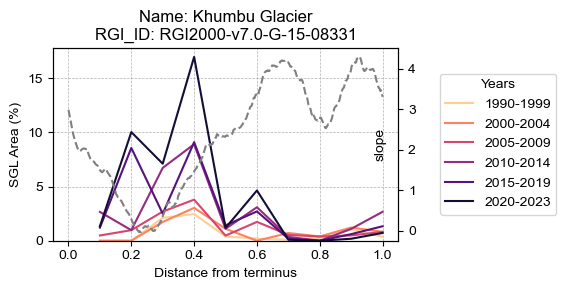

In [9]:
rgi_id = 'RGI2000-v7.0-G-15-08331' # choose which you want to provide
glacier_name = 'Khumbu'
plot_single_glacier_slope(rgi_id, glacier_name)